## Practica 1 - Computer Vision

In [1]:
import os
import gdown

# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")


Downloading...
From (original): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE
From (redirected): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE&confirm=t&uuid=1e32a557-34e5-4746-b5a8-cf29ce9ab851
To: /content/data/practica_1_dataset.zip
100%|██████████| 69.6M/69.6M [00:01<00:00, 38.8MB/s]


In [2]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)
subfolders = ["test", "train", "valid"]
full_paths = [os.path.join(data_dir, folder) for folder in subfolders]

if not all(os.path.isdir(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test, train and valid folders already exist")

In [3]:
import pandas as pd
data_dir = "data"
df = pd.read_csv(os.path.join(data_dir, "test", "annotations.csv"))
print(f"{df.shape = }")
df.head()

df.shape = (584, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,406,457,497,533
1,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,18,705,82,759
2,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,51,426,116,475
3,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,428,331,504,376
4,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,0,613,21,658


In [4]:
import os
import pandas as pd
import numpy as np

def annotation_to_labels(annotations_path):
    # Load the annotations
    df = pd.read_csv(annotations_path)

    # Count the number of instances of each class per image
    count_class = df.groupby(["filename", "class"]).size()

    # Compute the area of each bounding box
    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    # Compute the area of each class per image
    area_class = df.groupby(["filename", "class"])["area"].sum()

    # Compute the score as AREA * COUNT
    score = pd.Series(area_class * count_class, name="score").reset_index()

    # Group by filename and get the class with the highest score
    df_labels = score.groupby("filename").max().reset_index()

    return df_labels["filename"].values, df_labels["class"].values

data_dir = "data"
filenames, labels = annotation_to_labels(os.path.join(data_dir, "test", "annotations.csv"))
filenames[:5], labels[:5]

(array(['IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg',
        'IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg',
        'IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg',
        'IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg',
        'IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg'],
       dtype=object),
 array(['puffin', 'penguin', 'penguin', 'penguin', 'penguin'], dtype=object))

In [5]:
import shutil
def organize_by_label(filenames, labels, data_dir):
    # Define input and output paths
    filepaths = np.char.add(data_dir + os.sep, filenames)
    organized_filepaths = np.char.add(data_dir + os.sep + labels + os.sep, filenames)

    # Create a directory for each label
    for label in np.unique(labels):
        os.makedirs(data_dir + os.sep + label, exist_ok=True)

    # Move files to their respective directories
    def move_file(src, dest):
        try:
            shutil.move(src, dest)
            return True  # File moved successfully
        except FileNotFoundError:
            if not os.path.exists(dest):
                print(f"Annotated file not found: {src}")
            return False  # File does not exist
        except Exception as e:
            return f"Error: {e}"

    return np.vectorize(move_file)(filepaths, organized_filepaths)

set_names = ["train", "valid", "test"]
for set_name in set_names:
    data_dir = os.path.join("data", set_name)
    filenames, labels = annotation_to_labels(os.path.join(data_dir, "annotations.csv"))
    organize_by_label(filenames, labels, data_dir)

In [13]:
!pip install tensorflow
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


Example

In [14]:
data_dir = os.path.join("data", "test")
image_paths = tf.data.Dataset.list_files(
    data_dir + os.sep + '*/*.jpg',
    shuffle=False
)  # Note: Pattern only looks inside subfolders
print(image_paths.as_numpy_iterator().next())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'


## Create tf.data.Dataset

In [15]:
set_names = ["train", "valid", "test"]
data_dir = "data"
def get_jpg_ds(set_names, data_dir):
    return {
        name: tf.data.Dataset.list_files(
            os.path.join(data_dir, name) + os.sep + '*/*.jpg',
            shuffle=False,
        )
        for name in set_names
    }
ds = get_jpg_ds(set_names, data_dir)
ds

{'train': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'valid': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'test': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>}

In [16]:
next(ds["test"].as_numpy_iterator())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'

From our tensors that are image paths we extract labels, this is a light weight operation so we keep it in cache and perform all the normalization, that is, convert to onehot encoding

In [17]:
class_mapping = {
    0: b"fish",
    1: b"jellyfish",
    2: b"penguin",
    3: b"puffin",
    4: b"shark",
    5: b"starfish",
    6: b"stingray",
}

class_lookup_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(class_mapping.values())),
        values=tf.constant(list(class_mapping.keys()), dtype=tf.int64)
    ),
    default_value=-1
)

def get_label(image_path):
    label = tf.strings.split(image_path, os.sep)[-2]
    label = class_lookup_table.lookup(label)
    label = tf.one_hot(label, len(class_mapping))
    return label

def update_ds(ds, func):
    for key in ds.keys():
        ds[key] = ds[key].map(
            func,
            num_parallel_calls=tf.data.AUTOTUNE
        )

set_names = ["train", "valid", "test"]
data_dir = "data"

ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))

ds["test"].as_numpy_iterator().next()

(b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg',
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [18]:
def get_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

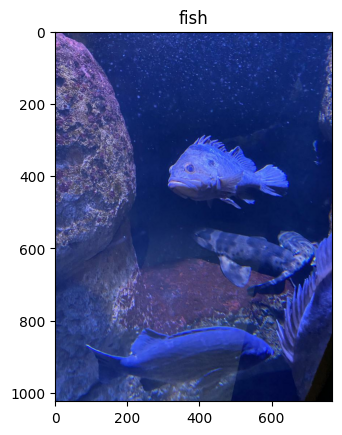

In [19]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [20]:
ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

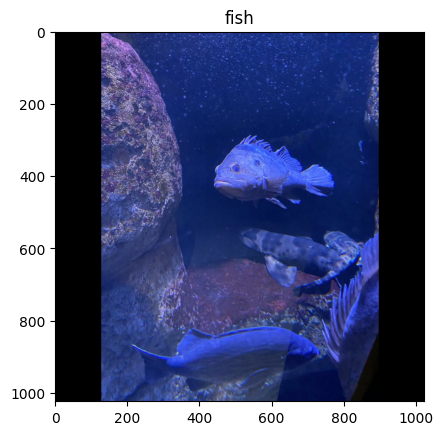

In [21]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [22]:
def resize_and_keep_uint8(image, height=224, width=224):
    resized_image = tf.image.resize(image, [height, width])  # Resize
    resized_image = tf.clip_by_value(resized_image, 0, 255)  # Ensure values remain valid
    resized_image = tf.cast(resized_image, tf.uint8)  # Convert back to uint8
    return resized_image

ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [23]:
def standardize_image(image, label):
    image = tf.cast(image, tf.float32)
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    image = (image - mean) / (std + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero
    return image, label

update_ds(ds, lambda x, y: (standardize_image(x, y)))

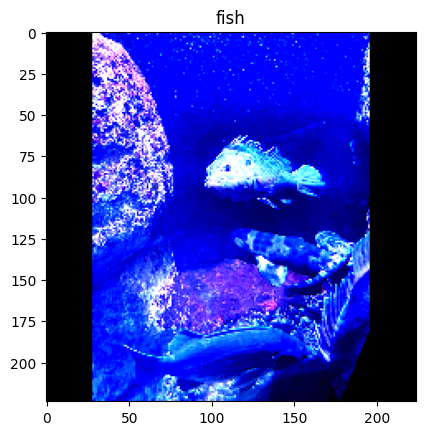

In [24]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [25]:
ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [26]:
print(len(ds["train"]), len(ds["valid"]))

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4,
                                                    dtype=tf.int32))
    original_size = tf.shape(image)[:2]
    scale = tf.random.uniform([], 0.8, 1.0)
    new_size = tf.cast(tf.cast(original_size, tf.float32) * scale, tf.int32)
    image = tf.image.random_crop(image, [new_size[0], new_size[1], tf.shape(image)[2]])
    image = tf.image.resize(image, original_size)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
ds_fit = (
    ds["train"]
    .cache()
    .map(augment, num_parallel_calls=AUTOTUNE)
    .shuffle(len(ds["train"]))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds["valid"]
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_test = (
    ds["test"]
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

447 127


In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 10
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=epoch_wait, restore_best_weights=True)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [28]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D, GlobalAveragePooling2D, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_model(base_model, lr_patience, num_classes, learning_rate=0.001, early_stop_patience=10, lr_factor=0.2):
    """
    Construye un modelo CNN personalizable para clasificación de imágenes.

    Parámetros:
    -----------
    base_model: modelo - Modelo base pre-entrenado
    lr_patience: int - Número de épocas sin mejora antes de reducir la tasa de aprendizaje
    num_classes: int - Número de clases para la clasificación
    learning_rate: float - Tasa de aprendizaje inicial
    early_stop_patience: int - Número de épocas sin mejora antes de detener el entrenamiento
    lr_factor: float - Factor de reducción de la tasa de aprendizaje
    """

    # --- Configuración de callbacks para optimizar el entrenamiento ---
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=lr_factor,
        patience=lr_patience,
        min_lr=0.0001
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=early_stop_patience,
        restore_best_weights=True
    )

    callbacks = [early_stopping, reduce_lr]

    # --- ARQUITECTURA DEL MODELO ---
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation ='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # --- COMPILACIÓN DEL MODELO ---
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model, callbacks

# Configuración general
num_classes = 7
IMG_SIZE = 224
learning_rate = 0.001
early_stop_patience = 10

# Lista de configuraciones de lr_patience para cada modelo
lr_patience_configs = [8, 4, 2]

# Creación y entrenamiento de los modelos en un bucle
models = []
histories = []

for i, lr_patience in enumerate(lr_patience_configs, 1):
    print(f"\nCreando y entrenando el modelo {i} con lr_patience={lr_patience}")
    # Modelo base
    base_model = MobileNetV3Large(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Fine-tuning de las últimas 15 capas
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model, callbacks = build_model(
        base_model,
        lr_patience=lr_patience,
        num_classes=num_classes,
        learning_rate=learning_rate,
        early_stop_patience=early_stop_patience
    )

    history = model.fit(
        ds_fit,
        epochs=100,
        validation_data=ds_val,
        callbacks=callbacks
    )

    models.append(model)
    histories.append(history)

    print(f"Entrenamiento del modelo {i} completado.")


Creando y entrenando el modelo 1 con lr_patience=8
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2233 - loss: 2.7489 - precision: 0.2238 - recall: 0.1296 - val_accuracy: 0.2441 - val_loss: 1.8996 - val_precision: 0.2794 - val_recall: 0.1496 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4857 - loss: 1.5927 - precision: 0.5411 - recall: 0.3418 - val_accuracy: 0.3858 - val_loss: 1.6781 - val_precision: 0.4706 - val_recall: 0.3150 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6222 - loss: 1.1755 - precision: 0.6892 - recall: 0.5091 - val_accuracy: 0.4882 - val_loss: 1.4755 - val_precision: 0.5510 - val_recall: 0.4252 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7201 - loss: 0.8115 - precision: 0.8040 - recall: 0.6558 - val_accuracy: 0.5906 - val_loss: 1.3826 - val_precision: 0.6346 - val_recall: 0.5197 - learning_rate: 0.0010
Epoch 5/100
14/1

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


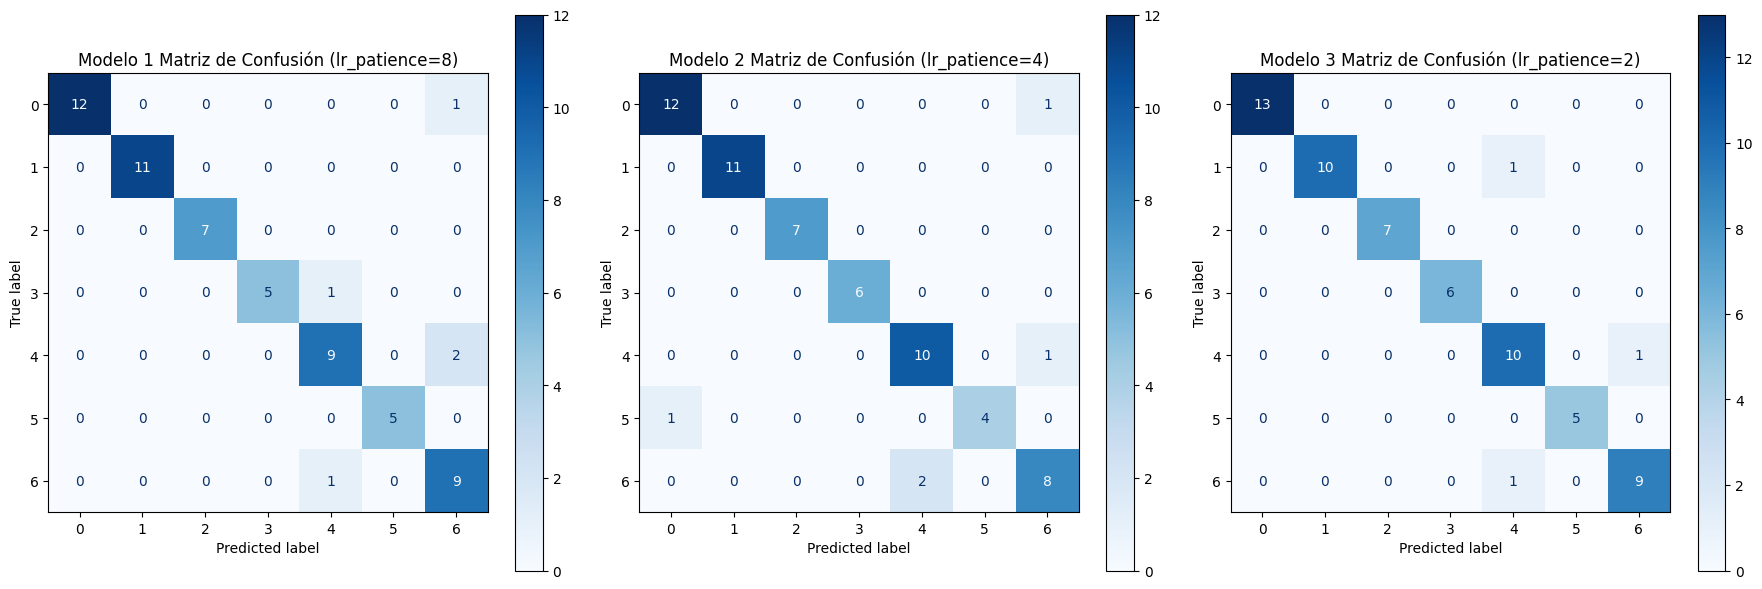

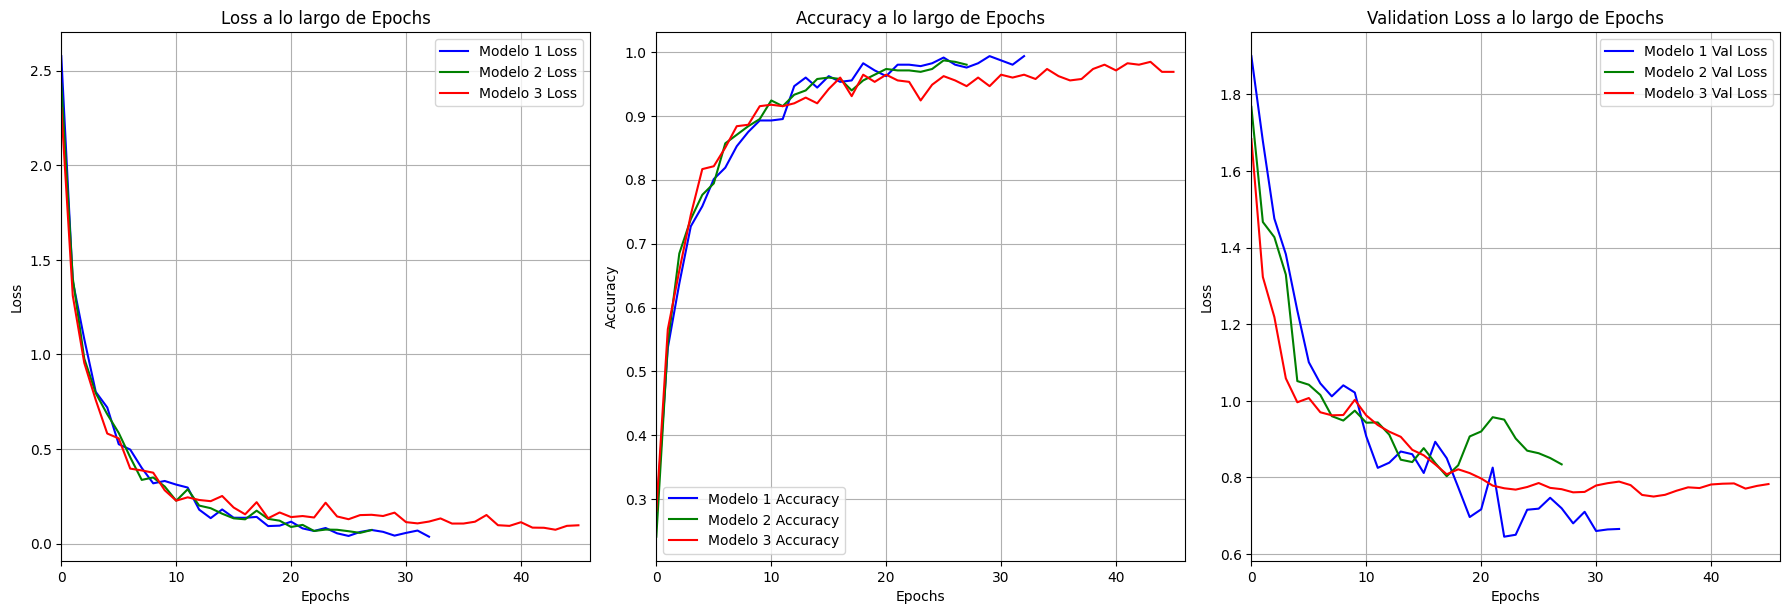

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones de los modelos para el conjunto de validación
y_preds = []
for i, model in enumerate(models):
    y_pred = np.argmax(model.predict(ds_test), axis=1)
    y_preds.append(y_pred)

# Obtener etiquetas verdaderas del conjunto de validación
y_true = []
for x, y in ds_test:
    y_true.extend(np.argmax(y.numpy(), axis=1))
y_true = np.array(y_true)

# Calcular matrices de confusión
cms = []
for y_pred in y_preds:
    cm = confusion_matrix(y_true, y_pred)
    cms.append(cm)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, cm in enumerate(cms):
    disp = ConfusionMatrixDisplay(cm).plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'Modelo {i+1} Matriz de Confusión (lr_patience={lr_patience_configs[i]})')
plt.tight_layout()
plt.show()

# Visualizar curvas de aprendizaje
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Colores para cada modelo
colors = ['blue', 'green', 'red']

# Visualizar curvas de pérdida
for i, history in enumerate(histories):
    axs[0].plot(history.history['loss'], label=f'Modelo {i+1} Loss', color=colors[i])
axs[0].set_title('Loss a lo largo de Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Visualizar curvas de precisión
for i, history in enumerate(histories):
    axs[1].plot(history.history['accuracy'], label=f'Modelo {i+1} Accuracy', color=colors[i])
axs[1].set_title('Accuracy a lo largo de Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Visualizar curvas de pérdida de validación
for i, history in enumerate(histories):
    axs[2].plot(history.history['val_loss'], label=f'Modelo {i+1} Val Loss', color=colors[i])
axs[2].set_title('Validation Loss a lo largo de Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid()

# Encontrar los límites máximos para todos los gráficos
max_epochs = max([len(history.history['loss']) for history in histories])

# Establecer los mismos límites para todos los ejes x
for ax in axs:
    ax.set_xlim(0, max_epochs)

# Hacer que los gráficos sean cuadrados
for ax in axs:
    ax.set_box_aspect(1)  # Esto hace que la relación de aspecto sea 1:1 (cuadrado)

plt.tight_layout()
plt.show()

In [34]:
for model in models:
  model.evaluate(ds_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9263 - loss: 0.2330 - precision: 0.9452 - recall: 0.9053
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9367 - loss: 0.1668 - precision: 0.9570 - recall: 0.9367
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9578 - loss: 0.1725 - precision: 0.9570 - recall: 0.9368
